## Project: Zillow's market value estimation

**Introduction:**\
A Zestimate is Zillow’s estimated market value for a home, computed using a proprietary formula including public and user-submitted data, such as details about a home (bedrooms, bathrooms, home age, etc.), location, property tax assessment information and sales histories of the subject home as well as other homes that have recently sold in the area.

**Objective:**\
In this competition, Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as\
$logerror=log(Zestimate)−log(SalePrice)$\
and it is recorded in the transactions file train.csv. In this competition, you are going to predict the logerror for the months in Fall 2017.\[1pt]

### Import of python libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

### Import of the data

In [2]:
import os
 
# get current directory
path = os.getcwd()
print("Current Directory", path)
 
# prints parent directory
print(os.path.abspath(os.path.join(path, os.pardir)))

Current Directory C:\Users\lucap\Documents\Luca_documents\Stanford Uni\BUS 48 Data Analytics\project\bus48-zillow-dataset\notebook
C:\Users\lucap\Documents\Luca_documents\Stanford Uni\BUS 48 Data Analytics\project\bus48-zillow-dataset


In [3]:
# zillow_dict explains the fields of the available data
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))
data_path = '\\data\\'

df_clean = pd.read_csv(parent_path + data_path + 'iheoma_cleaned.csv')

In [4]:
df_clean.head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolcnt,poolsizesum,regionidzip,roomcnt,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,taxvaluedollarcnt,assessmentyear
0,10859147,0.0,0.0,0.0,5068.0,6037,0.0,0.0,0.0,7521.0,0.0,0.0,96424.0,0.0,1.0,0.0,1948.0,1.0,1156834.0,2015.0
1,10879947,0.0,0.0,0.0,1776.0,6037,0.0,0.0,0.0,8512.0,0.0,0.0,96450.0,0.0,1.0,0.0,1947.0,1.0,433491.0,2015.0
2,10898347,0.0,0.0,0.0,2400.0,6037,0.0,0.0,0.0,2500.0,0.0,0.0,96446.0,0.0,1.0,0.0,1943.0,1.0,283315.0,2015.0
3,10940747,0.0,0.0,0.0,3611.0,6037,0.0,0.0,0.0,5333.0,0.0,0.0,96434.0,0.0,1.0,0.0,1946.0,1.0,688486.0,2015.0
4,10976347,0.0,0.0,0.0,3754.0,6037,0.0,0.0,0.0,7494.0,0.0,0.0,96366.0,0.0,1.0,0.0,1978.0,1.0,261201.0,2015.0


In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848903 entries, 0 to 848902
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      848903 non-null  int64  
 1   basementsqft                  848903 non-null  float64
 2   bathroomcnt                   848903 non-null  float64
 3   bedroomcnt                    848903 non-null  float64
 4   calculatedfinishedsquarefeet  848903 non-null  float64
 5   fips                          848903 non-null  int64  
 6   fireplacecnt                  848903 non-null  float64
 7   garagecarcnt                  848903 non-null  float64
 8   garagetotalsqft               848903 non-null  float64
 9   lotsizesquarefeet             848903 non-null  float64
 10  poolcnt                       848903 non-null  float64
 11  poolsizesum                   848903 non-null  float64
 12  regionidzip                   848903 non-nul

In [6]:
df_clean.drop(['parcelid'], axis=1, inplace=True)

### Downsample the dataset

In [7]:
# Randomly sample 20% of the original dataframe
df_down = df_clean.sample(frac=0.2)
print('The original df has shape:  %s' % (df_clean.shape,))
print('and the new df has shape: %s' % (df_down.shape,))

The original df has shape:  (848903, 19)
and the new df has shape: (169781, 19)


In [8]:
df_label = df_down['taxvaluedollarcnt']
df_data = df_down.loc[:, df_down.columns != 'taxvaluedollarcnt']
print('df_label has shape:  %s' % (df_label.shape,))
print('df_data has shape: %s' % (df_data.shape,))

df_label has shape:  (169781,)
df_data has shape: (169781, 18)


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_data, df_label, test_size=0.2, random_state=42)

In [10]:
from sklearn.linear_model    import LinearRegression
from sklearn.tree            import DecisionTreeRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.ensemble        import GradientBoostingRegressor
import xgboost as xgb
import statistics
from sklearn.model_selection import KFold,cross_val_score, train_test_split
from sklearn.metrics         import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer

In [11]:
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

In [12]:
models = {
    'LinearRegression':          LinearRegression(),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
    'KNeighborsRegressor':       KNeighborsRegressor(),
    'XGBRegressor':              xgb.XGBRegressor(
                                    colsample_bytree=0.4603, 
                                    gamma=0.0468, 
                                    learning_rate=0.05, 
                                    max_depth=3, 
                                    min_child_weight=1.7817, 
                                    n_estimators=100,
                                    reg_alpha=0.4640, 
                                    reg_lambda=0.8571,
                                    subsample=0.5213
                                 ),
    'GradientBoostingRegressor': GradientBoostingRegressor(
                                    n_estimators=100, 
                                    learning_rate=0.05,
                                    max_depth=4, 
                                    max_features='sqrt',
                                    min_samples_leaf=15, 
                                    min_samples_split=10, 
                                    loss='huber',
                                 ),
}

In [13]:
def evaluate_model(pipeline, X, y, kf):
    cv_mae = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    cv_mse = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_r2  = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    
    mae = -statistics.mean(cv_mae)
    mse = -statistics.mean(cv_mse)
    rmse = np.sqrt(mse)
    r2 = statistics.mean(cv_r2)
    
    return mae, mse, rmse, r2

In [14]:
import time

results = {}

kf = KFold(n_splits=5, shuffle=True)

for name, model in models.items():

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    print(f'Model {name} begining now ...')
    begin_time = time.time()
    mae, mse, rmse, r2 = evaluate_model(pipeline, df_data, df_label, kf)
    end_time = time.time()
    print(f'Model {name} finishing in'.ljust(50), f'{round((end_time - begin_time) / 60, 1)} minutes')

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2
    }

Model LinearRegression begining now ...



KeyboardInterrupt



In [65]:
df_results = pd.DataFrame(results).T
df_results

,MAE,MSE,RMSE,R^2
LinearRegression,201909.346353,1.355340e+11,368149.382572,0.339698
DecisionTreeRegressor,212843.325318,1.922111e+11,438418.899493,0.127010
KNeighborsRegressor,199674.359245,1.367955e+11,369858.807550,0.336258
XGBRegressor,184768.113368,1.153862e+11,339685.404997,0.439224
GradientBoostingRegressor,180576.945355,1.270109e+11,356385.907854,0.382344


C:\Users\lucap\AnacondaPy3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


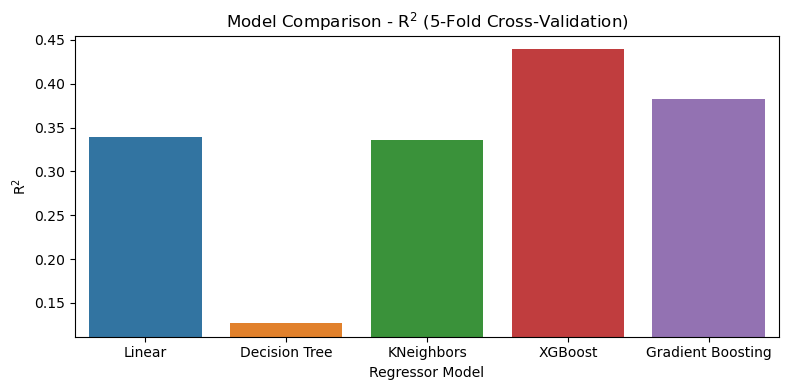

In [66]:
%matplotlib inline
df_results.reset_index(inplace=True)
rmse_df = df_results[['index', 'R^2']]

labels = ['Linear', 'Decision Tree', 'KNeighbors', 'XGBoost', 'Gradient Boosting']

plt.figure(figsize=(8, 4))
sns.barplot(data=rmse_df, x=labels, y='R^2')

plt.title(r'Model Comparison - R$^{2}$ (5-Fold Cross-Validation)')
plt.xlabel("Regressor Model")
plt.axhline(y=0, color='k', linestyle=':')
plt.ylabel(r'R$^{2}$')
yminlim = rmse_df['R^2'].min()
ymaxlim = rmse_df['R^2'].max()
yrange = (ymaxlim - yminlim) * .05
yminlim -= yrange
ymaxlim += yrange
plt.ylim(yminlim, ymaxlim)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [67]:
best_regressor_name = df_results.sort_values(by=['R^2'],ascending=False).head(1)['index'].iloc[-1]
best_regressor = models[best_regressor_name]

In [68]:
best_regressor_name

'XGBRegressor'

In [20]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)

X_test_sc = scaler.transform(X_test)

In [70]:
best_model = best_regressor.fit(X_train_sc, y_train)

In [71]:
pred = best_model.predict(X_test_sc)

In [72]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(y_test, pred))
rms = mean_squared_error(y_test, pred, squared=False)
print(rms)

0.43079912938718756
345429.61664188164


In [73]:
idx = 2
print('The true value is: ' +str(y_test.iloc[idx]))
print('and the predicted value is: ' +str(best_model.predict(X_test_sc[idx].reshape(1, -1))))

The true value is: 589204.0
and the predicted value is: [665218.44]


In [74]:
from joblib import dump

# Save the best model to disk
model_filename = f'best_model_{best_regressor_name.replace(" ", "_").lower()}.joblib'
dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as best_model_xgbregressor.joblib


In [75]:
# save X_train, X_test, y_train, y_test to csv
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

### NN model

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [ ]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_sc.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])

model.summary()

learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=adam, loss='mean_squared_error', metrics=[r2_metric])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation split and early stopping
history = model.fit(X_train_sc, y_train, 
                    validation_split=0.2, 
                    epochs=500, 
                    batch_size=512, 
                    callbacks=[early_stopping])

# The model will stop training when the validation loss stops improving
print("Training stopped at epoch:", len(history.history['loss']))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               9728      
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_11 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 256)              

In [23]:
history.history.keys()

dict_keys(['loss', 'r2_metric', 'val_loss', 'val_r2_metric'])

dict_keys(['loss', 'r2_metric', 'val_loss', 'val_r2_metric'])


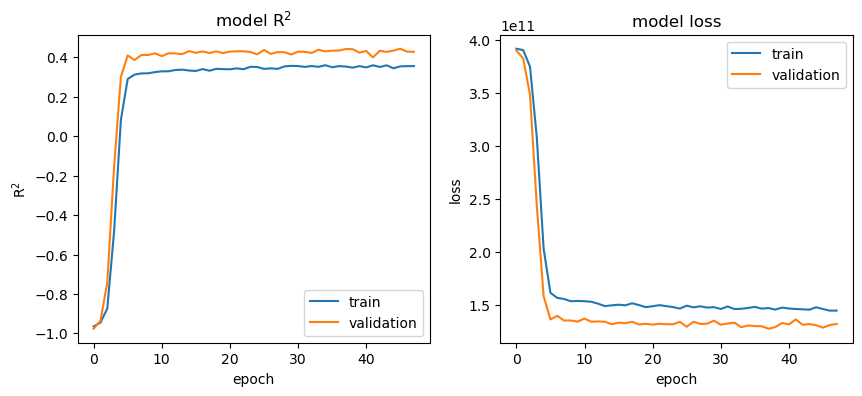

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
ax0.plot(history.history['r2_metric'])
ax0.plot(history.history['val_r2_metric'])
ax0.set_title('model R$^{2}$')
ax0.set_ylabel('R$^{2}$')
ax0.set_xlabel('epoch')
ax0.legend(['train', 'validation'], loc=4)
# summarize history for loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc=1)
plt.show()

In [123]:
# Make predictions
y_pred_nn = model.predict(X_test_sc)

1062/1062 [==============================] - 5s 5ms/step


In [124]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 score:", r2_score(y_test, y_pred_nn))

Root Mean Squared Error (RMSE): 343537.41286685277
R2 score: 0.4370180177151044


In [128]:
# Save the NN model
model.save('NN_model.h5')